# How to train an MLP using the Pipeline

## Import classes and define paths

In [ ]:
from pyLOM import NN
from pathlib import Path

import torch

import warnings
warnings.filterwarnings("ignore")

In [2]:
DATA_DIR = Path.cwd().parent.parent.parent.parent / "Testsuite/DATA"
CASE_DIR = Path.cwd() / "results"

NN.create_results_folder(CASE_DIR / 'models')
NN.create_results_folder(CASE_DIR / 'hyperparameters')
NN.create_results_folder(CASE_DIR / 'plots')

Folder already exists: /home/david/Desktop/pyLowOrder/docs/source/notebook_examples/NN/results/models
Folder already exists: /home/david/Desktop/pyLowOrder/docs/source/notebook_examples/NN/results/hyperparameters
Folder already exists: /home/david/Desktop/pyLowOrder/docs/source/notebook_examples/NN/results/plots


## Define scalers if needed

Here, we create 2 minmax scalers, one for scaling the inputs, and other for the outputs. They will be passed to the dataset and the data will be automatically scaled

In [3]:
input_scaler = NN.MinMaxScaler()
output_scaler = NN.MinMaxScaler()

## Create datasets
For this example, a dataset of airfoils generated with XFoil is used. As inputs, the model will receive the x and y coordinates of a point of the airfoil, the Reynolds number and the angle of attack; and the output will be the cp on that point

In [4]:
dataset = NN.Dataset.load(
    DATA_DIR / 'AIRFOIL.h5',
    field_names=["cp"],
    add_mesh_coordinates=True,
    variables_names=["AoA", "Re"],
    inputs_scaler=input_scaler,
    outputs_scaler=output_scaler,
)
train_dataset, test_dataset = dataset.get_splits_by_parameters([0.8, 0.2])

After creating the datasets, we can see the shape of the tensors

In [ ]:
x, y = train_dataset[:]
print("\tTrain dataset length: ", len(train_dataset))
print("\tTest dataset length: ", len(test_dataset))
print("\tX, y train shapes:", x.shape, y.shape)

	Train dataset length:  27720
	Test dataset length:  6831
	X, y train shapes: torch.Size([27720, 4]) torch.Size([27720, 1])


## Model creation

Now, the only thing left is creating the model. For this example we are using an `MLP`

In [6]:
training_params = {
    "epochs": 250,
    "lr": 0.00015,
    "lr_gamma": 0.98,
    "lr_scheduler_step": 15,
    "batch_size": 512,
    "loss_fn": torch.nn.MSELoss(),
    "optimizer_class": torch.optim.Adam,
    "print_rate_epoch": 10,
}

In [7]:
model = NN.MLP(
    input_size=x.shape[1],
    output_size=y.shape[1],
    hidden_size=128,
    n_layers=3,
    p_dropouts=0.1,
)

## Run the pipeline

In [8]:
pipeline = NN.Pipeline(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    model=model,
    training_params=training_params,
)
training_logs = pipeline.run()

Epoch 10/250 | Train loss (x1e5) 1298.3891  | Test loss (x1e5) 703.0160
Epoch 20/250 | Train loss (x1e5) 797.9615  | Test loss (x1e5) 349.2481
Epoch 30/250 | Train loss (x1e5) 579.6663  | Test loss (x1e5) 227.8643
Epoch 40/250 | Train loss (x1e5) 444.7827  | Test loss (x1e5) 153.3643
Epoch 50/250 | Train loss (x1e5) 372.1323  | Test loss (x1e5) 118.2516
Epoch 60/250 | Train loss (x1e5) 322.1863  | Test loss (x1e5) 83.2253
Epoch 70/250 | Train loss (x1e5) 275.1737  | Test loss (x1e5) 62.4014
Epoch 80/250 | Train loss (x1e5) 255.4608  | Test loss (x1e5) 44.5339
Epoch 90/250 | Train loss (x1e5) 230.0541  | Test loss (x1e5) 37.5939
Epoch 100/250 | Train loss (x1e5) 211.6728  | Test loss (x1e5) 34.3095
Epoch 110/250 | Train loss (x1e5) 201.9902  | Test loss (x1e5) 33.0887
Epoch 120/250 | Train loss (x1e5) 186.0425  | Test loss (x1e5) 26.0977
Epoch 130/250 | Train loss (x1e5) 173.7337  | Test loss (x1e5) 26.0191
Epoch 140/250 | Train loss (x1e5) 161.6373  | Test loss (x1e5) 27.8452
Epoch 150

To save the model:

In [10]:
model.save(path=str(CASE_DIR / "models"))

## Show plots

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def true_vs_pred_plot(y_true, y_pred):
    """
    Auxiliary function to plot the true vs predicted values
    """
    num_plots = y_true.shape[1]
    plt.figure(figsize=(10, 5 * num_plots))
    for j in range(num_plots):
        plt.subplot(num_plots, 1, j + 1)
        plt.scatter(y_true[:, j], y_pred[:, j], s=1, c="b", alpha=0.5)
        plt.xlabel("True values")
        plt.ylabel("Predicted values")
        plt.title(f"Scatterplot for Component {j+1}")
        plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_train_test_loss(train_loss, test_loss):
    """
    Auxiliary function to plot the training and test loss
    """
    plt.figure()
    plt.plot(range(1, len(train_loss) + 1), train_loss, label="Training Loss")
    total_epochs = len(test_loss) # test loss is calculated at the end of each epoch
    total_iters = len(train_loss) # train loss is calculated at the end of each iteration/batch
    iters_per_epoch = total_iters // total_epochs
    plt.plot(np.arange(iters_per_epoch, total_iters+1, step=iters_per_epoch), test_loss, label="Test Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Training Loss vs Epoch")
    plt.yscale("log")
    plt.legend()
    plt.grid()
    plt.show()

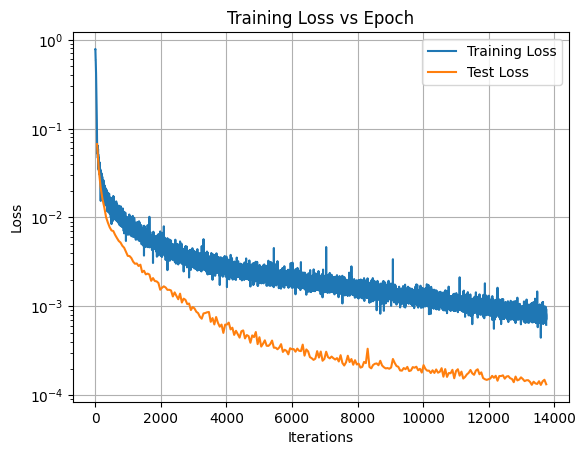

In [10]:
plot_train_test_loss(training_logs['train_loss'], training_logs['test_loss'])

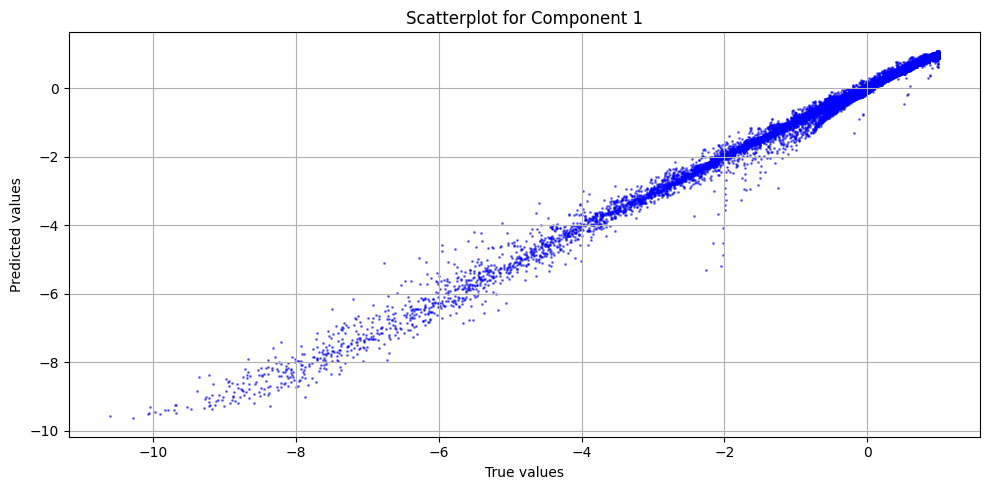

In [11]:
preds = model.predict(train_dataset, batch_size=250)

scaled_preds = output_scaler.inverse_transform([preds])[0]
scaled_y = output_scaler.inverse_transform([train_dataset[:][1]])[0]
true_vs_pred_plot(scaled_y, scaled_preds)

## Evaluate the model with some metrics

In [12]:
evaluator = NN.RegressionEvaluator()
evaluator(scaled_y, scaled_preds)
evaluator.print_metrics()


Regression evaluator metrics:
mse: 0.0152
rmse: 0.1233
mae: 0.0645
mre: 89.3139%
ae_95: 0.2164
ae_99: 0.4968
r2: 0.9919
l2_error: 0.0838
